In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_D860.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,pub_rec,months_cr_line,term,initial_list_status,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,0.126095,-0.171185,1.284007,-0.832409,-0.832409,-0.628702,0.113224,-0.289595,-1.128516,-0.366924,-0.906273,-0.442383,-0.031863,-0.15631,-0.039654,-0.794874,1.082347,-1.814253,-0.063823,0.881236,-1.281964,0.948529,-0.031863,-0.948582,-0.363362,1.202768,-0.164570,-0.309121,-0.805499,-0.284851,-0.12429,-0.188982,-0.218681,4.927682,-0.545315,-0.055244,-0.132453,-0.177146,-0.055244,-0.699590,-0.761661,1.512173,0.0
1,-1.706372,-0.161231,-0.572577,-0.554658,-0.554658,-0.628702,-1.710281,-0.817722,-0.306473,-0.324679,-0.906273,-0.442383,-0.031863,-0.15631,-0.106365,-0.859867,-0.323706,-0.261957,-0.063823,0.881236,-1.281964,-0.107952,-0.031863,-0.948582,-0.363362,1.202768,-0.164570,-0.309121,-0.805499,-0.284851,-0.12429,-0.188982,-0.218681,-0.202935,1.833803,-0.055244,-0.132453,-0.177146,-0.055244,1.429409,-0.761661,-0.661300,0.0
2,0.237154,0.037836,-0.953746,-0.832409,-0.832409,1.340048,0.279158,-0.113553,-0.224269,-0.575234,-0.025894,-0.442383,-0.031863,-0.15631,-0.106365,-0.857026,3.894453,0.382842,-0.063823,0.881236,0.780053,-1.692673,-0.031863,-0.948582,-0.363362,1.202768,-0.164570,-0.309121,-0.805499,3.510602,-0.12429,-0.188982,-0.218681,-0.202935,-0.545315,-0.055244,-0.132453,-0.177146,-0.055244,-0.699590,1.312919,-0.661300,1.0
3,0.806329,-0.151278,-0.184372,0.556348,0.556348,1.340048,0.856971,-0.113553,-0.964107,-0.641515,-0.906273,-0.442383,-0.031863,-0.15631,-0.106365,-0.704978,-0.323706,-0.429128,-0.063823,0.881236,0.780053,-0.900312,-0.031863,-0.948582,-0.363362,1.202768,-0.164570,-0.309121,-0.805499,-0.284851,-0.12429,-0.188982,-0.218681,-0.202935,-0.545315,-0.055244,-0.132453,5.645057,-0.055244,1.429409,-0.761661,-0.661300,1.0
4,1.070094,-0.186115,0.938023,0.556348,0.556348,1.340048,1.124656,-0.113553,-0.470882,0.020928,-0.906273,-0.442383,-0.031863,-0.15631,-0.106365,0.498734,-0.323706,-0.644061,-0.063823,0.881236,0.780053,-1.428552,-0.031863,1.054205,-0.363362,-0.831416,6.076436,-0.309121,-0.805499,-0.284851,-0.12429,-0.188982,-0.218681,-0.202935,-0.545315,-0.055244,-0.132453,-0.177146,-0.055244,-0.699590,-0.761661,1.512173,0.0


In [4]:
data.shape

(986, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    828
0.0    158
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(986, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.83838384 0.84263959 0.83756345 0.83756345 0.83756345]
0.8387427575244834


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  5, 153],
       [  6, 822]])

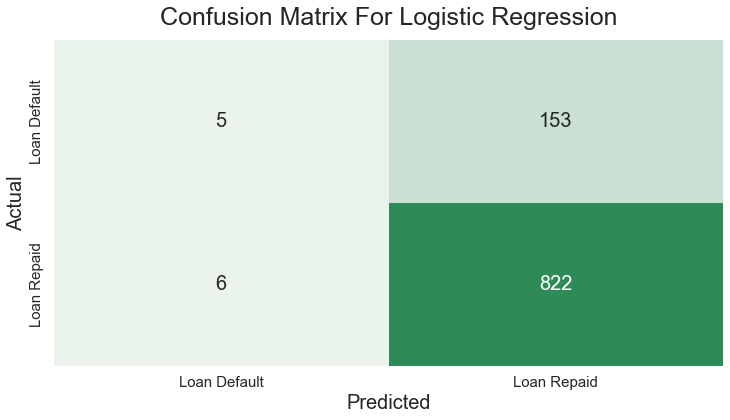

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.8387423935091278

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

822
153
6
5
0.8387423935091278


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    828
0.0    158
Name: loan_status_bin, dtype: int64

0.8397565922920892


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8430769230769231

In [17]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [18]:
y_pred_prob

array([[0.20543296, 0.79456704],
       [0.0861859 , 0.9138141 ],
       [0.15649402, 0.84350598],
       ...,
       [0.26899329, 0.73100671],
       [0.16739697, 0.83260303],
       [0.23246784, 0.76753216]])

In [19]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1.

In [20]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 66,  92],
       [217, 611]])

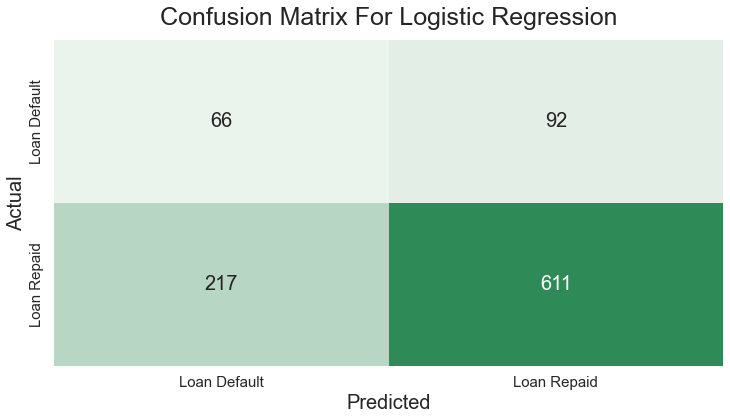

In [21]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [22]:
accuracy_score(y, y_pred_success)

0.6866125760649088

In [23]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

611
92
217
66
0.6866125760649088


In [24]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8691322901849218

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 